In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Let's what what's in these tables...
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
print('measurement columns:')
for c in columns:
    print(c['name'], c["type"])
columns = inspector.get_columns('station')
print()
print('station columns:')
for c in columns:
    print(c['name'], c["type"])    
    
# Find the most recent date in the data set.
dates = session.query(Measurement.date).distinct().order_by(desc(Measurement.date)).all()
max_date = dates[0][0]
max_date

measurement columns:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station columns:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


'2017-08-23'

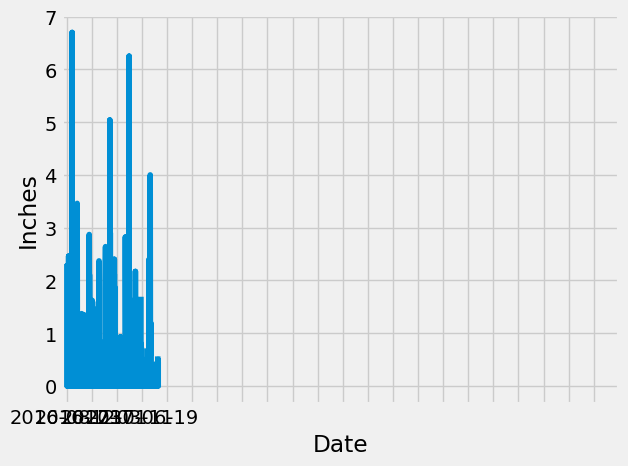

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200])

In [125]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
# I didn't find a direct way to subtract years, and since leap years
# are a thing I don't want to use days or weeks. So just set the year.
# I'm also subtracting an extra day so I  don't have to do exact matching
# in the query which gets around different string formatting.
max_date_dt = dt.datetime.strptime(max_date, '%Y-%m-%d')
start_date = dt.datetime(max_date_dt.year-1, max_date_dt.month, max_date_dt.day-1)

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > start_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_year, columns=["date", "prcp"])

# Sort the dataframe by date
# This is redudndant since I ordered it with the query above
df = df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df["date"], df["prcp"])
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(np.arange(0, len(df.index), step=100)) #!!!
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')

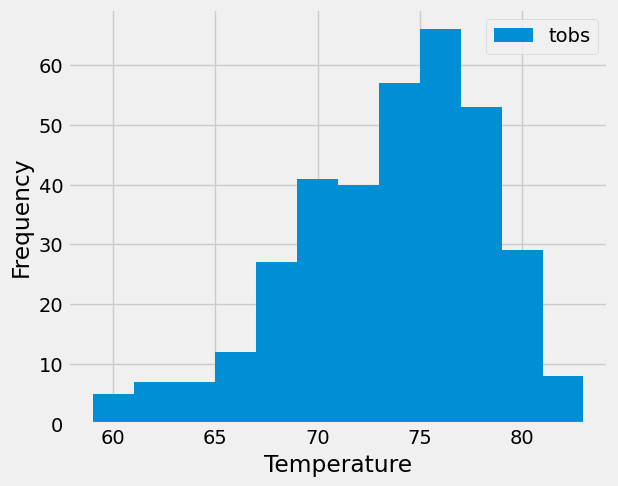

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()